In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, RNN, SimpleRNNCell, Embedding, LSTM, GRU, Bidirectional
import numpy as np

In [4]:
# Download and extract dataset
os.system('wget https://www.dropbox.com/s/pdhwlpi2yeie0ol/movie-reviews-dataset.zip')
os.system('unzip -q "/kaggle/working/movie-reviews-dataset.zip"')

def prepare_data(dir):
    data = text_dataset_from_directory(dir)
    return data.map(lambda text, label: (regex_replace(text, '<br />', ' '), label))

--2025-07-18 02:43:40--  https://www.dropbox.com/s/pdhwlpi2yeie0ol/movie-reviews-dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/4r8fb499vfpyrw44fgftj/movie-reviews-dataset.zip?rlkey=79qfzf6683udd2ehdii38y7wt [following]
--2025-07-18 02:43:41--  https://www.dropbox.com/scl/fi/4r8fb499vfpyrw44fgftj/movie-reviews-dataset.zip?rlkey=79qfzf6683udd2ehdii38y7wt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdfc27d515a1f4efb593823cdd5.dl.dropboxusercontent.com/cd/0/inline/Ctv2M91ZcpMHEWTMvzdDsXvQPS19YLx-woFtB5LihUNjzGrlGgT132ywmc3E7H-BpjhoHV8MjiIA9CkfjJt41rDlWKdzyO6CMPxAtHn6JQq4PHvo1hXBWp9OXMh9VNqBCH7mYFG5qWw235vawfAI154s/file# [following]
--2025-07-18 02:43:41--  https://ucdfc27d515a1f4efb593823cdd5.

In [5]:

train_data = prepare_data('/kaggle/working/movie-reviews-dataset/train')
test_data = prepare_data('/kaggle/working/movie-reviews-dataset/test')

for text_batch, label_batch in train_data.take(1):
    print(text_batch.numpy()[0])
    print(label_batch.numpy()[0])

max_tokens = 1000
max_len = 100

Found 25000 files belonging to 2 classes.


I0000 00:00:1752806661.529814      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752806661.530534      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 25000 files belonging to 2 classes.
b'I\'ve read reviews that apparently you have to have been a student in a very strict, British school in the 1960\'s to understand this. Maybe that\'s true, if so, then this movie is outdated.  *************SPOILER ALERT**************************************** The ending makes about as much sense as all the kids who\'re anti-government and anti-corporation without having any better solution that doesn\'t torch society to a Mad Max type cinder.  Yeah, the main characters could leave, but they don\'t. The reasons they go about this don\'t make sense. There isn\'t enough character development to explain why. What shooting up a bunch of innocent people is supposed to mean is never explained or even hinted at. It is mentioned that war is the final creative expression, quite possibly the only revelation that any characters of this movie have, and it makes no sense.  The characters who go on a murder spree aren\'t fighting the institution, they\'re ju

In [6]:
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_len,
)

train_texts = train_data.map(lambda text, label: text)
vectorize_layer.adapt(train_texts)

In [7]:
def build_model(rnn_layer):
    model = Sequential([
        Input(shape=(1,), dtype="string"),
        vectorize_layer,
        Embedding(max_tokens + 1, 128),
        rnn_layer,
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
    return model

In [8]:
rnn_layers = [
    RNN(SimpleRNNCell(64), return_sequences=False),
    LSTM(64),
    GRU(64),
    Bidirectional(LSTM(64)),
    Bidirectional(GRU(64))
]

In [9]:
histories = []
models = []
for rnn_layer in rnn_layers:
    model = build_model(rnn_layer)
    history = model.fit(train_data, epochs=20)
    histories.append(history)
    models.append(model)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 92ms/step - accuracy: 0.5117 - loss: 0.6955
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.5668 - loss: 0.6806
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.5271 - loss: 0.6891
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.5592 - loss: 0.6815
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.5522 - loss: 0.6836
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.5980 - loss: 0.6609
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.6049 - loss: 0.6549
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.6306 - loss: 0.6404
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.5832 - loss: 0.6629
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.6430 - loss: 0.6270
Epoch 11/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.6514 - loss: 0.6187
Epoch 12/20
782/782 ━━━━━━━━━━

I0000 00:00:1752808131.201052     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6253 - loss: 0.6315
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7506 - loss: 0.5199
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7961 - loss: 0.4426
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8078 - loss: 0.4235
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8175 - loss: 0.3991
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8248 - loss: 0.3841
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8365 - loss: 0.3586
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8484 - loss: 0.3394
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8572 - loss: 0.3227
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8680 - loss: 0.3054
Epoch 11/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8789 - loss: 0.2832
Epoch 12/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy

In [10]:
# Evaluate models and select the best one
best_model = None
best_accuracy = 0
best_model_index = 0

for i, model in enumerate(models):
    _, accuracy = model.evaluate(test_data, verbose=0)
    print(f"Model {i+1} Test Accuracy: {accuracy*100:.2f}%")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_index = i

print(f"\nBest model is Model {best_model_index+1} with accuracy: {best_accuracy*100:.2f}%")

Model 1 Test Accuracy: 63.89%
Model 2 Test Accuracy: 76.27%
Model 3 Test Accuracy: 75.83%
Model 4 Test Accuracy: 77.07%
Model 5 Test Accuracy: 75.90%

Best model is Model 4 with accuracy: 77.07%


In [11]:

# Save the best model
best_model.save('best_model.h5')
print("Best model saved as 'best_model.h5'")

Best model saved as 'best_model.h5'


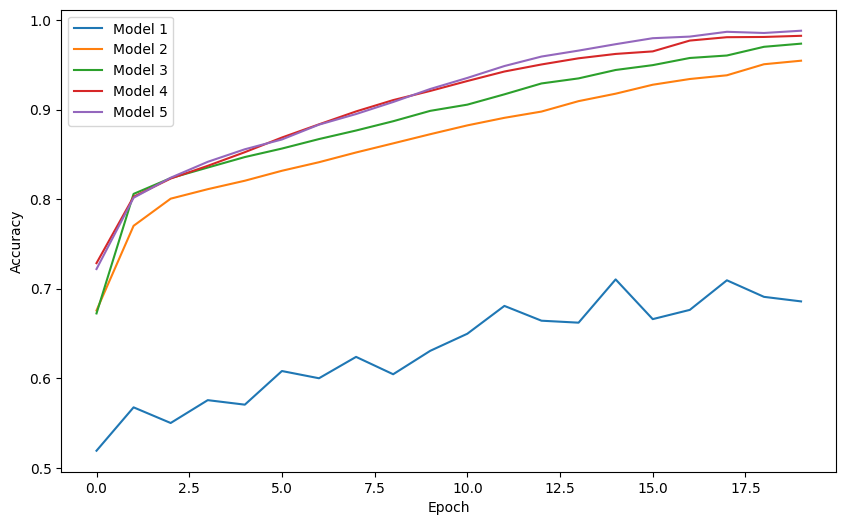

In [13]:
# Plot accuracy
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Model {i + 1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# Print final accuracies
print("\nFinal Training Accuracies:")
for i, history in enumerate(histories):
    accuracy = history.history['accuracy'][-1]
    print(f"Model {i + 1}: {accuracy * 100:.2f}%")


Final Training Accuracies:
Model 1: 68.58%
Model 2: 95.46%
Model 3: 97.36%
Model 4: 98.24%
Model 5: 98.81%


In [15]:
# Create a download link for the best model (for Colab)
from google.colab import files

def download_best_model():
    files.download('best_model.h5')

print("\nTo download the best model, run: download_best_model()")


To download the best model, run: download_best_model()
